# Time Series Forecast: Features &rarr; Emissions (monthly resolution)

### Further tasks to be determined and evaluated:
- Different learning rates
- Different scalers
- Different batch sizes
- Visualize training in tensorboard
- Apply feature selection 
- Make decision on 'look_back' and 'horizon'

### Import libraries

In [79]:
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA

from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input, Conv1D, Activation, Dropout, Lambda, Multiply, Add, Concatenate, GlobalMaxPooling1D
from keras.layers import Dense, Flatten, InputLayer, LSTM, AveragePooling1D, BatchNormalization, MaxPooling1D, GlobalAveragePooling1D

### Some useful functions

In [80]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [81]:
def plot_model_history(history, ax=None, metric='loss', ep_start=1, ep_stop=None, monitor='val_loss', mode='min', plttitle=None):
    if ax is None:
        fig,ax = plt.subplots()
    if ep_stop is None:
        ep_stop = len(history.epoch)
    if plttitle is None:
        plttitle = metric[0].swapcase() + metric[1:] + ' During Training'
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history[metric][ep_start-1:ep_stop])
    ax.plot(np.arange(ep_start,ep_stop+1, dtype='int'),history.history['val_' + metric][ep_start-1:ep_stop])
    ax.set(title = plttitle)
    ax.set(ylabel = metric[0].swapcase() + metric[1:])
    ax.set(xlabel = 'Epoch')
    ax.legend(['train', 'val'], loc = 'upper right', fontsize='x-large')
    ax.yaxis.set_tick_params(labelsize=18)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.set_xlabel('Epoch',fontsize = 18)
    ax.set_ylabel('Loss',fontsize = 18)
    ax.set_title(plttitle, fontsize=20)

### Read in input data (features) - X

In [82]:
with open('../../data/feature_database.json') as json_database:
    database = json.load(json_database)
# Concat data
feature_data = None
for i in database:
    # Filter emission data
    if (database[i]['sector'] != 'target_values' and 
        database[i]['sector'] != 'greenhouse_emissions'):
        new_data = pd.read_json(database[i]['data'])
        if feature_data is None:
            feature_data = new_data
        else:
            feature_data = pd.concat([feature_data, new_data], axis=1, join="inner")
    else:
        continue
        #print(f"Feature not used: {i}")
        
date_first = feature_data.index[0]
date_last = feature_data.index[-1]
first_date = date_first.strftime("%m/%Y")
last_date = date_last.strftime("%m/%Y")
feature_data = feature_data.values
feature_data = feature_data.astype('float64')
print(f"Shape input data (samples, features): {feature_data.shape}")
print(f"Input data starts at: {first_date} and ends at: {last_date}")

Shape input data (samples, features): (111, 40)
Input data starts at: 01/2011 and ends at: 03/2020


### Read in target data (emissions) - y

In [83]:
emission_data = pd.read_csv('../../data/greenhouse_emissions/oeko-institut_sektorale_abgrenzung_treibhausgasemissionen_daten_sektor_monthly.csv')
emission_data = emission_data['Total_CO2_Emission'].values
emission_data = emission_data.astype('float64')

# Take only the emissions on which we have indicators
emission_data = emission_data[21*12:31*12-9] # from: 01/2011 - until: 03/2020
print(f"Shape output data (samples, emission): {emission_data.shape}")

Shape output data (samples, emission): (111,)


### Data preparation

In [84]:
def prepare_data(input_data, output_data, look_back=1, horizon=1, shuffle=False, apply_pca=False, pca_comp=10, scaler = None):
    
    dataX, dataY = [], []
    
    # Check data requirements
    if len(input_data) != len(output_data):
        raise ValueError('Input and ouput do not have same length!')
    
    # Apply PCA to data
    if apply_pca:
        pca = PCA(n_components = pca_comp)
        input_data = pca.fit_transform(input_data)
        print(f"PCA applied on feature input data - New feature input shape: {input_data.shape}")
        
    # Apply data scaler
    if scaler == None:
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'Standard':
        scaler = StandardScaler()
        input_data = scaler.fit_transform(input_data)
    elif scaler == 'MinMax':
        scaler = MinMaxScaler()
        input_data = scaler.fit_transform(input_data)
    else:
        raise ValueError('scaler variable has to be either \'Standard\' or \'MinMax\'!')           
    
    # Apply 'windowing' to data
    #for i in range(len(input_data)-look_back-horizon):
        #dataX.append(input_data[i:(i+look_back)])
        #dataY.append(output_data[(i+look_back):(i+look_back+horizon)])
    for i in range(len(input_data)-look_back+1):
        dataX.append(input_data[i:(i+look_back), :])
        dataY.append(emission_data[i+look_back:i+look_back+horizon])
    
    # Shuffle data
    if shuffle is True:
        random.seed(42)
        dataX, dataY = shuffle(dataX, dataY, random_state=42)
        
    return np.array(dataX), np.array(dataY)

### Define dataset properties

In [85]:
look_back = 12        # months to look back (input data)
horizon = 6           # months to look ahead (target data)
split_ratio = 0.75    # split ratio training / testing 
shuffle = True        # shuffle data yes / no
pca = False           # apply PCA to input data yes / no
scaler = 'Standard'   # choose data scaling method ...
                      # ... either 'Standard' or 'MinMax'

    
# Split into train and test sets according to split_ratio
train_size = int(len(feature_data) * split_ratio)
test_size = len(feature_data) - train_size
if test_size < (look_back + horizon):
    raise ValueError('Split ratio too small. Increase test size!')

## Define different neural network architectures

### Multi Layer Perceptron - MLP (vanilla)

In [86]:
def create_mlp(look_back, horizon, plot_summary = False):
    
    model = Sequential(name='MLP')
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Flatten(name='MLP_flatten'))
    model.add(Dense(256, activation='elu', name='Dense_1'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='elu', name='Dense_2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(64, activation='elu', name='Dense_3'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    model.add(Dense(16, activation='elu', name='Dense_4'))
    model.add(BatchNormalization())
    #model.add(Dropout(0.1))
    model.add(Dense(horizon, activation='linear', name="MLP_final"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model             

### 1D Convolutional Neural Network - CNN (vanilla)

In [87]:
def create_cnn1D(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='CNN') 
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', name="Conv_1"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_1'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu', name="Conv_2"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_2'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', name="Conv_3"))
    #model.add(MaxPooling1D(pool_size=2, name='MaxPool_3'))
    model.add(BatchNormalization())
    model.add(Flatten())    
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name='Dense_1'))
    model.add(Dense(horizon, activation='linear', name="CNN_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model

### WaveNet (CNN like Neural Network Architecture) 
Reference: https://arxiv.org/pdf/1703.04691.pdf


In [88]:
def create_wavenet(look_back, horizon, plot_summary = False):   
    
    # convolutional operation parameters
    n_filters = 32 # 32 
    filter_width = 2
    dilation_rates = [2**i for i in range(4)] * 2 

    # define an input history series and pass it through a stack of dilated causal convolution blocks. 
    history_seq = Input(shape=(look_back, X_train.shape[2]))
    x = history_seq

    skips = []
    for dilation_rate in dilation_rates:

        # preprocessing - equivalent to time-distributed dense
        x = Conv1D(16, 1, padding='same', activation='relu')(x) 
        
        # filter convolution
        x_f = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)
        
        # gating convolution
        x_g = Conv1D(filters=n_filters,
                     kernel_size=filter_width, 
                     padding='causal',
                     dilation_rate=dilation_rate)(x)

        # multiply filter and gating branches
        z = Multiply()([Activation('tanh')(x_f),
                        Activation('sigmoid')(x_g)])

        # postprocessing - equivalent to time-distributed dense
        z = Conv1D(16, 1, padding='same', activation='relu')(z)

        # residual connection
        x = Add()([x, z])    

        # collect skip connections
        skips.append(z)

    # add all skip connection outputs 
    out = Activation('relu')(Add()(skips))

    # final time-distributed dense layers 
    out = Conv1D(128, 1, padding='same')(out)
    out = Activation('relu')(out)
    #out = Dropout(.1)(out)
    #out = Conv1D(1, 1, padding='same')(out)
    out = AveragePooling1D(3)(out)
    out = GlobalMaxPooling1D()(out)
    #out = Dense(32, activation='relu', name="second_last_dense_layer")(out)
    #out = Dropout(0.1)(out)
    #out = BatchNormalization()(out)
    out = Dense(horizon, activation='linear', name="final_dense_layer")(out)

    model = Model(history_seq, out, name='WaveNet')
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()   

    return model 

### Long Short-Term Memory - LSTM

In [89]:
def create_lstm(look_back, horizon, plot_summary = False):   
    
    model = Sequential(name='LSTM')    
    model.add(InputLayer(input_shape=(look_back, X_train.shape[2])))
    model.add(LSTM(256, return_sequences=True, name="LSTM_1"))
    model.add(BatchNormalization())
    model.add(LSTM(128, return_sequences=True, name="LSTM_2"))
    model.add(BatchNormalization())
    model.add(LSTM(64, return_sequences=False, name="LSTM_4"))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu', name="LSTM_Dense1"))
    #model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu', name="LSTM_Dense2"))
    #model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu', name="LSTM_Dense3"))    
    model.add(Dense(horizon,activation="linear",name="LSTM_output"))
    
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2_keras])
    
    if plot_summary:
        model.summary()       

    return model

### Create training and test set

In [90]:
X_train, y_train = prepare_data(feature_data[0:train_size,:],
                                emission_data[0:train_size],
                                look_back,
                                horizon)

print("Shape of training data:")
print(f'Training data - X: {X_train.shape}')
print(f'Training data - y: {y_train.shape}')

Shape of training data:
Training data - X: (72, 12, 40)
Training data - y: (72, 6)


In [91]:
X_test, y_test = prepare_data(feature_data[train_size:len(feature_data),:],
                              emission_data[train_size:len(emission_data)],
                              look_back,
                              horizon)

print("Shape of test data:")
print(f'Test data - X: {X_test.shape}')
print(f'Test data - y: {y_test.shape}')

Shape of test data:
Test data - X: (17, 12, 40)
Test data - y: (17, 6)


### Create an instance of every neural network architecture

In [92]:
wavenet = create_wavenet(look_back, horizon, plot_summary=True)
cnn1D = create_cnn1D(look_back, horizon, plot_summary=True)
lstm = create_lstm(look_back, horizon, plot_summary=True)
mlp = create_mlp(look_back, horizon, plot_summary=True)

Model: "WaveNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 12, 40)       0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 12, 16)       656         input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 12, 32)       1056        conv1d_34[0][0]                  
__________________________________________________________________________________________________
conv1d_36 (Conv1D)              (None, 12, 32)       1056        conv1d_34[0][0]                  
____________________________________________________________________________________________

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv1D)              (None, 8, 128)            25728     
_________________________________________________________________
batch_normalization_11 (Batc (None, 8, 128)            512       
_________________________________________________________________
Conv_2 (Conv1D)              (None, 4, 64)             41024     
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 64)             256       
_________________________________________________________________
Conv_3 (Conv1D)              (None, 2, 32)             6176      
_________________________________________________________________
batch_normalization_13 (Batc (None, 2, 32)             128       
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0       

### Train model of every instance and show train history

In [93]:
# Define callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)

# Train models
history_wavenet = wavenet.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
history_cnn1D = cnn1D.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
history_lstm = lstm.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])
history_mlp = mlp.fit(X_train, y_train, validation_split=0.2, epochs=250, batch_size=4, verbose=1, callbacks=[es])


Train on 57 samples, validate on 15 samples
Epoch 1/250
57/57 [==============================] - 3s 58ms/step - loss: 4612.4596 - r2_keras: -187.9149 - val_loss: 4342.6207 - val_r2_keras: -347.9178
Epoch 2/250
57/57 [==============================] - 0s 7ms/step - loss: 3643.4590 - r2_keras: -137.3622 - val_loss: 2743.6846 - val_r2_keras: -220.1934
Epoch 3/250
57/57 [==============================] - 0s 7ms/step - loss: 1490.7490 - r2_keras: -59.9049 - val_loss: 331.8729 - val_r2_keras: -26.3056
Epoch 4/250
57/57 [==============================] - 0s 7ms/step - loss: 207.1759 - r2_keras: -9.2985 - val_loss: 73.9846 - val_r2_keras: -4.1658
Epoch 5/250
57/57 [==============================] - 0s 7ms/step - loss: 58.4697 - r2_keras: -2.6528 - val_loss: 57.0203 - val_r2_keras: -3.9371
Epoch 6/250
57/57 [==============================] - 0s 7ms/step - loss: 35.9787 - r2_keras: -0.4105 - val_loss: 22.2678 - val_r2_keras: -0.7052
Epoch 7/250
57/57 [==============================] - 0s 7ms/ste

57/57 [==============================] - 0s 7ms/step - loss: 1.7329 - r2_keras: 0.9299 - val_loss: 1.9052 - val_r2_keras: 0.8456
Epoch 58/250
57/57 [==============================] - 0s 6ms/step - loss: 1.6710 - r2_keras: 0.9065 - val_loss: 1.9931 - val_r2_keras: 0.8377
Epoch 59/250
57/57 [==============================] - 0s 7ms/step - loss: 1.6477 - r2_keras: 0.9247 - val_loss: 2.2150 - val_r2_keras: 0.8155
Epoch 60/250
57/57 [==============================] - 0s 7ms/step - loss: 1.5173 - r2_keras: 0.9360 - val_loss: 2.3583 - val_r2_keras: 0.8027
Epoch 61/250
57/57 [==============================] - 0s 7ms/step - loss: 1.5224 - r2_keras: 0.9372 - val_loss: 1.8150 - val_r2_keras: 0.8499
Epoch 62/250
57/57 [==============================] - 0s 7ms/step - loss: 1.4389 - r2_keras: 0.9368 - val_loss: 1.8897 - val_r2_keras: 0.8386
Epoch 63/250
57/57 [==============================] - 0s 7ms/step - loss: 1.3680 - r2_keras: 0.9381 - val_loss: 1.9621 - val_r2_keras: 0.8370
Epoch 64/250
57/57 

57/57 [==============================] - 0s 2ms/step - loss: 4659.8808 - r2_keras: -231.4830 - val_loss: 4691.6112 - val_r2_keras: -375.4811
Epoch 3/250
57/57 [==============================] - 0s 2ms/step - loss: 4574.4164 - r2_keras: -195.4996 - val_loss: 4609.9029 - val_r2_keras: -369.0334
Epoch 4/250
57/57 [==============================] - 0s 2ms/step - loss: 4481.7713 - r2_keras: -184.2326 - val_loss: 4447.2994 - val_r2_keras: -355.3784
Epoch 5/250
57/57 [==============================] - 0s 2ms/step - loss: 4342.9519 - r2_keras: -192.1259 - val_loss: 4145.6422 - val_r2_keras: -329.6713
Epoch 6/250
57/57 [==============================] - 0s 2ms/step - loss: 4160.6293 - r2_keras: -223.0090 - val_loss: 3630.7653 - val_r2_keras: -288.5294
Epoch 7/250
57/57 [==============================] - 0s 2ms/step - loss: 3915.4645 - r2_keras: -176.5502 - val_loss: 3220.2160 - val_r2_keras: -254.8947
Epoch 8/250
57/57 [==============================] - 0s 2ms/step - loss: 3585.3181 - r2_keras:

Epoch 2/250
57/57 [==============================] - 1s 19ms/step - loss: 4697.5164 - r2_keras: -194.6634 - val_loss: 4704.4064 - val_r2_keras: -376.7299
Epoch 3/250
57/57 [==============================] - 1s 19ms/step - loss: 4458.0422 - r2_keras: -200.9446 - val_loss: 4533.3969 - val_r2_keras: -362.7481
Epoch 4/250
57/57 [==============================] - 1s 19ms/step - loss: 3859.9022 - r2_keras: -168.7029 - val_loss: 3869.9506 - val_r2_keras: -309.2265
Epoch 5/250
57/57 [==============================] - 1s 19ms/step - loss: 2580.1618 - r2_keras: -109.8692 - val_loss: 2319.0587 - val_r2_keras: -187.0088
Epoch 6/250
57/57 [==============================] - 1s 19ms/step - loss: 1709.4068 - r2_keras: -95.1259 - val_loss: 1484.9918 - val_r2_keras: -120.2356
Epoch 7/250
57/57 [==============================] - 1s 18ms/step - loss: 1252.8908 - r2_keras: -57.7610 - val_loss: 1525.9908 - val_r2_keras: -123.4100
Epoch 8/250
57/57 [==============================] - 1s 18ms/step - loss: 1028

57/57 [==============================] - 1s 18ms/step - loss: 43.5593 - r2_keras: -0.7904 - val_loss: 104.7550 - val_r2_keras: -8.0287
Epoch 57/250
57/57 [==============================] - 1s 19ms/step - loss: 49.1394 - r2_keras: -1.9354 - val_loss: 175.1868 - val_r2_keras: -13.1256
Epoch 58/250
57/57 [==============================] - 1s 17ms/step - loss: 32.8565 - r2_keras: -0.3262 - val_loss: 97.6363 - val_r2_keras: -6.6993
Epoch 59/250
57/57 [==============================] - 1s 18ms/step - loss: 40.4511 - r2_keras: -1.5259 - val_loss: 224.1310 - val_r2_keras: -16.9983
Epoch 60/250
57/57 [==============================] - 1s 18ms/step - loss: 38.8593 - r2_keras: -0.5293 - val_loss: 51.0217 - val_r2_keras: -2.9890
Epoch 61/250
57/57 [==============================] - 1s 18ms/step - loss: 43.0073 - r2_keras: -0.9824 - val_loss: 189.0588 - val_r2_keras: -14.2183
Epoch 62/250
57/57 [==============================] - 1s 18ms/step - loss: 38.5843 - r2_keras: -0.7659 - val_loss: 234.4467 

Epoch 21/250
57/57 [==============================] - 0s 2ms/step - loss: 4286.0718 - r2_keras: -180.3074 - val_loss: 4236.1756 - val_r2_keras: -335.9935
Epoch 22/250
57/57 [==============================] - 0s 2ms/step - loss: 4234.8750 - r2_keras: -170.7680 - val_loss: 4114.1976 - val_r2_keras: -325.1249
Epoch 23/250
57/57 [==============================] - 0s 2ms/step - loss: 4184.8948 - r2_keras: -191.4131 - val_loss: 4214.5678 - val_r2_keras: -336.5850
Epoch 24/250
57/57 [==============================] - 0s 2ms/step - loss: 4131.0295 - r2_keras: -186.5915 - val_loss: 4017.3635 - val_r2_keras: -319.8546
Epoch 25/250
57/57 [==============================] - 0s 2ms/step - loss: 4073.6774 - r2_keras: -172.1345 - val_loss: 4011.5969 - val_r2_keras: -318.3101
Epoch 26/250
57/57 [==============================] - 0s 2ms/step - loss: 4018.7587 - r2_keras: -188.8510 - val_loss: 3956.2634 - val_r2_keras: -315.1464
Epoch 27/250
57/57 [==============================] - 0s 2ms/step - loss: 39

57/57 [==============================] - 0s 2ms/step - loss: 891.1377 - r2_keras: -37.1019 - val_loss: 865.4702 - val_r2_keras: -67.9851
Epoch 75/250
57/57 [==============================] - 0s 2ms/step - loss: 849.0224 - r2_keras: -35.9342 - val_loss: 807.2462 - val_r2_keras: -63.7826
Epoch 76/250
57/57 [==============================] - 0s 2ms/step - loss: 806.4211 - r2_keras: -37.2426 - val_loss: 774.8830 - val_r2_keras: -60.3000
Epoch 77/250
57/57 [==============================] - 0s 2ms/step - loss: 763.3663 - r2_keras: -31.4930 - val_loss: 724.1186 - val_r2_keras: -56.8220
Epoch 78/250
57/57 [==============================] - 0s 2ms/step - loss: 721.0230 - r2_keras: -27.2633 - val_loss: 686.6448 - val_r2_keras: -54.0195
Epoch 79/250
57/57 [==============================] - 0s 2ms/step - loss: 682.6562 - r2_keras: -26.0542 - val_loss: 642.9123 - val_r2_keras: -50.5936
Epoch 80/250
57/57 [==============================] - 0s 2ms/step - loss: 646.0539 - r2_keras: -30.7618 - val_los

57/57 [==============================] - 0s 2ms/step - loss: 17.6913 - r2_keras: 0.2776 - val_loss: 15.8087 - val_r2_keras: -0.3328
Epoch 130/250
57/57 [==============================] - 0s 2ms/step - loss: 17.6803 - r2_keras: 0.0438 - val_loss: 15.3027 - val_r2_keras: -0.3140
Epoch 131/250
57/57 [==============================] - 0s 2ms/step - loss: 17.8504 - r2_keras: 0.0045 - val_loss: 12.9937 - val_r2_keras: -0.1110
Epoch 132/250
57/57 [==============================] - 0s 2ms/step - loss: 14.3559 - r2_keras: 0.1072 - val_loss: 11.1019 - val_r2_keras: 0.0785
Epoch 133/250
57/57 [==============================] - 0s 2ms/step - loss: 17.1579 - r2_keras: 0.2403 - val_loss: 11.4874 - val_r2_keras: 0.0175
Epoch 134/250
57/57 [==============================] - 0s 2ms/step - loss: 14.5889 - r2_keras: -0.0296 - val_loss: 9.2960 - val_r2_keras: 0.2214
Epoch 135/250
57/57 [==============================] - 0s 2ms/step - loss: 14.7919 - r2_keras: 0.2931 - val_loss: 11.0537 - val_r2_keras: 0.0

57/57 [==============================] - 0s 2ms/step - loss: 11.9819 - r2_keras: 0.3496 - val_loss: 4.2670 - val_r2_keras: 0.6894
Epoch 187/250
57/57 [==============================] - 0s 2ms/step - loss: 6.5473 - r2_keras: 0.6270 - val_loss: 3.9171 - val_r2_keras: 0.7181
Epoch 188/250
57/57 [==============================] - 0s 2ms/step - loss: 9.1125 - r2_keras: 0.5482 - val_loss: 5.8097 - val_r2_keras: 0.5741
Epoch 189/250
57/57 [==============================] - 0s 2ms/step - loss: 8.2766 - r2_keras: 0.5001 - val_loss: 3.5592 - val_r2_keras: 0.7489
Epoch 190/250
57/57 [==============================] - 0s 2ms/step - loss: 9.7606 - r2_keras: 0.5336 - val_loss: 5.0538 - val_r2_keras: 0.6383
Epoch 191/250
57/57 [==============================] - 0s 2ms/step - loss: 7.1242 - r2_keras: 0.6645 - val_loss: 4.4043 - val_r2_keras: 0.6968
Epoch 192/250
57/57 [==============================] - 0s 2ms/step - loss: 10.9669 - r2_keras: 0.4512 - val_loss: 3.9832 - val_r2_keras: 0.7235
Epoch 193/2

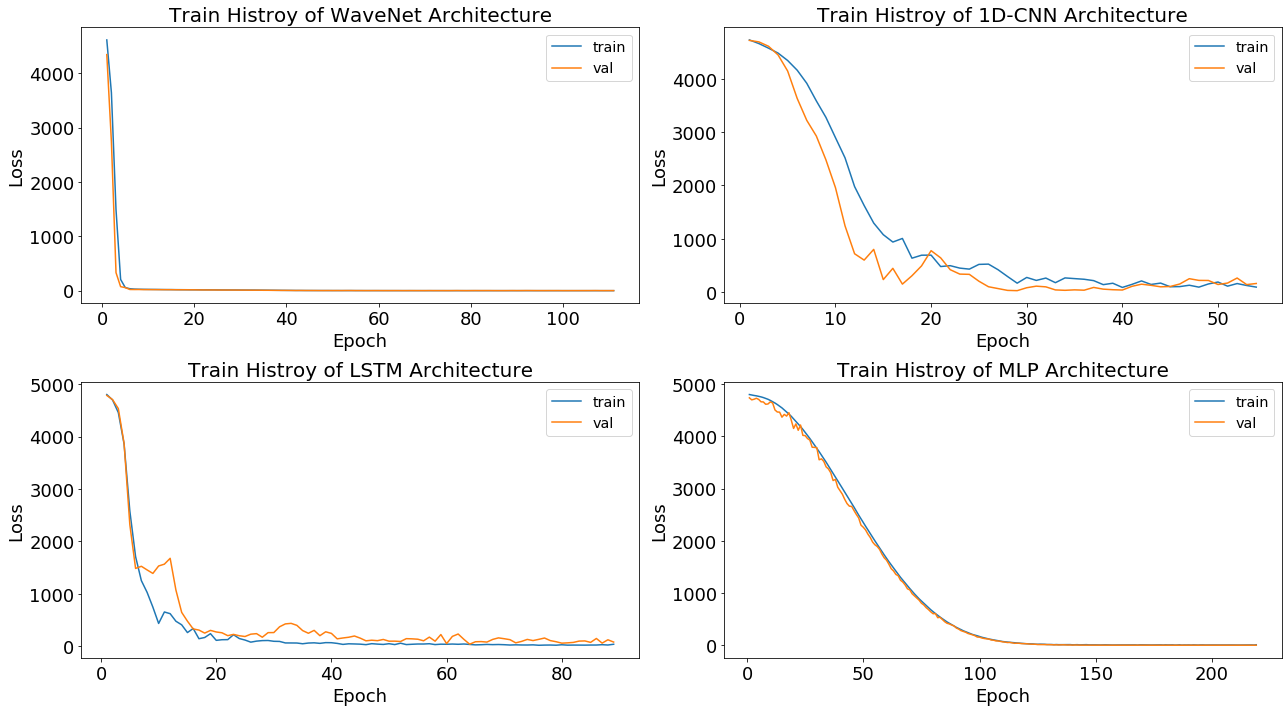

In [94]:
# plot training history for every model
fig, ax = plt.subplots(2, 2, figsize=(18,10))
plot_model_history(history_wavenet, ax = ax[0,0], plttitle='Train Histroy of WaveNet Architecture')
plot_model_history(history_cnn1D, ax = ax[0,1], plttitle='Train Histroy of 1D-CNN Architecture')
plot_model_history(history_lstm, ax = ax[1,0], plttitle='Train Histroy of LSTM Architecture')
plot_model_history(history_mlp, ax = ax[1,1], plttitle='Train Histroy of MLP Architecture')
plt.tight_layout()

### Evaluate performance of models

WaveNet Train Score: 0.97 MSE (0.98 RMSE)
WaveNet Test Score: 10.37 MSE (3.22 RMSE)
1D-CNN Train Score: 101.12 MSE (10.06 RMSE)
1D-CNN Test Score: 251.92 MSE (15.87 RMSE)
LSTM Train Score: 32.54 MSE (5.70 RMSE)
LSTM Test Score: 74.08 MSE (8.61 RMSE)
MLP Train Score: 3.73 MSE (1.93 RMSE)
MLP Test Score: 11.68 MSE (3.42 RMSE)


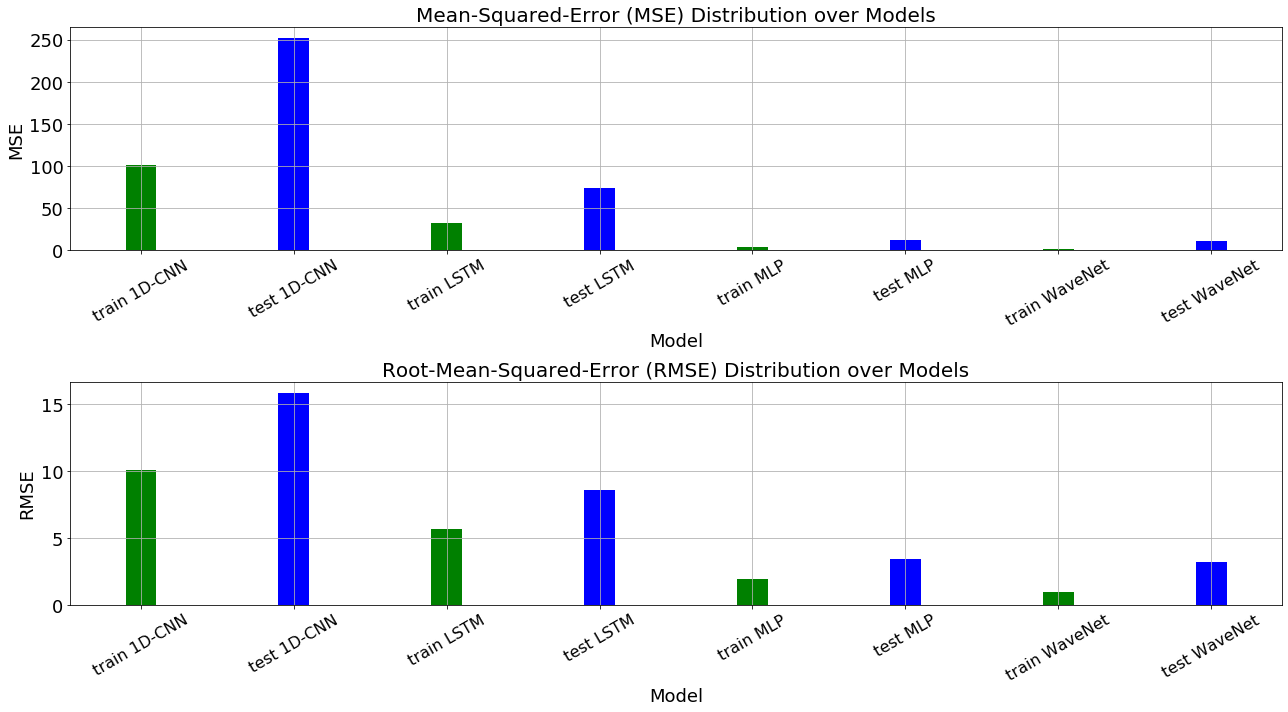

In [95]:
# WaveNet
trainScore_wavenet = wavenet.evaluate(X_train, y_train, verbose=0)
print('WaveNet Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_wavenet[0], math.sqrt(trainScore_wavenet[0])))
testScore_wavenet = wavenet.evaluate(X_test, y_test, verbose=0)
print('WaveNet Test Score: %.2f MSE (%.2f RMSE)' % (testScore_wavenet[0], math.sqrt(testScore_wavenet[0])))

# 1D-CNN
trainScore_cnn1D = cnn1D.evaluate(X_train, y_train, verbose=0)
print('1D-CNN Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_cnn1D[0], math.sqrt(trainScore_cnn1D[0])))
testScore_cnn1D = cnn1D.evaluate(X_test, y_test, verbose=0)
print('1D-CNN Test Score: %.2f MSE (%.2f RMSE)' % (testScore_cnn1D[0], math.sqrt(testScore_cnn1D[0])))

# LSTM
trainScore_lstm = lstm.evaluate(X_train, y_train, verbose=0)
print('LSTM Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_lstm[0], math.sqrt(trainScore_lstm[0])))
testScore_lstm = lstm.evaluate(X_test, y_test, verbose=0)
print('LSTM Test Score: %.2f MSE (%.2f RMSE)' % (testScore_lstm[0], math.sqrt(testScore_lstm[0])))

# MLP
trainScore_mlp = mlp.evaluate(X_train, y_train, verbose=0)
print('MLP Train Score: %.2f MSE (%.2f RMSE)' % (trainScore_mlp[0], math.sqrt(trainScore_mlp[0])))
testScore_mlp = mlp.evaluate(X_test, y_test, verbose=0)
print('MLP Test Score: %.2f MSE (%.2f RMSE)' % (testScore_mlp[0], math.sqrt(testScore_mlp[0])))

# Plot Errorbars (MSE & RMSE) for train and test
fig, ax = plt.subplots(2, figsize=(18,10))

ax[0].bar([1,2,3,4,5,6,7,8], [trainScore_cnn1D[0], testScore_cnn1D[0], trainScore_lstm[0], testScore_lstm[0], trainScore_mlp[0], testScore_mlp[0], trainScore_wavenet[0], testScore_wavenet[0]], width=0.2, color=['green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue'])
ax[0].set_title('Mean-Squared-Error (MSE) Distribution over Models', fontsize=20)
ax[0].set_xlabel('Model', fontsize=18)
ax[0].set_ylabel('MSE', fontsize=18)
ax[0].set_xticks(np.arange(1,9))
ax[0].set_xticklabels(['train 1D-CNN', 'test 1D-CNN', 'train LSTM', 'test LSTM', 'train MLP', 'test MLP', 'train WaveNet', 'test WaveNet'], rotation=30, fontsize=16)
ax[0].yaxis.set_tick_params(labelsize=18)
ax[0].grid()

ax[1].bar([1,2,3,4,5,6,7,8], [math.sqrt(trainScore_cnn1D[0]), math.sqrt(testScore_cnn1D[0]), math.sqrt(trainScore_lstm[0]), math.sqrt(testScore_lstm[0]), math.sqrt(trainScore_mlp[0]), math.sqrt(testScore_mlp[0]), math.sqrt(trainScore_wavenet[0]), math.sqrt(testScore_wavenet[0])], width=0.2, color=['green', 'blue', 'green', 'blue', 'green', 'blue', 'green', 'blue'])
ax[1].set_title('Root-Mean-Squared-Error (RMSE) Distribution over Models', fontsize=20)
ax[1].set_xlabel('Model', fontsize=18)
ax[1].set_ylabel('RMSE', fontsize=18)
ax[1].set_xticks(np.arange(1,9))
ax[1].set_xticklabels(['train 1D-CNN', 'test 1D-CNN', 'train LSTM', 'test LSTM', 'train MLP', 'test MLP', 'train WaveNet', 'test WaveNet'], rotation=30, fontsize=16)
ax[1].yaxis.set_tick_params(labelsize=18)
ax[1].grid()

plt.tight_layout()

### Model prediction

In [96]:
# Select latest possible input data
X_predict = np.zeros((1, look_back, X_train.shape[2]))
X_predict[0] = feature_data[len(feature_data)-look_back:, :]

In [97]:
# WaveNet
trainPredict_wavenet = wavenet.predict(X_train)
testPredict_wavenet = wavenet.predict(X_test)
prediction_wavenet = wavenet.predict(X_predict)
print(f"WaveNet forecast for the next {horizon} months: {np.around(prediction_wavenet, 1)} (mio. tonnes CO2)")

# 1D-CNN
trainPredict_cnn1D = cnn1D.predict(X_train)
testPredict_cnn1D = cnn1D.predict(X_test)
prediction_cnn1D = cnn1D.predict(X_predict)
print(f"1D-CNN forecast for the next {horizon} months: {np.around(prediction_cnn1D, 1)} (mio. tonnes CO2)")

# LSTM
trainPredict_lstm = lstm.predict(X_train)
testPredict_lstm = lstm.predict(X_test)
prediction_lstm = lstm.predict(X_predict)
print(f"LSTM forecast for the next {horizon} months: {np.around(prediction_lstm, 1)} (mio. tonnes CO2)")

# MLP
trainPredict_mlp = mlp.predict(X_train)
testPredict_mlp = mlp.predict(X_test)
prediction_mlp = mlp.predict(X_predict)
print(f"MLP forecast for the next {horizon} months: {np.around(prediction_mlp, 1)} (mio. tonnes CO2)")

WaveNet forecast for the next 6 months: [[76.3 74.9 72.6 70.7 70.2 67.3]] (mio. tonnes CO2)
1D-CNN forecast for the next 6 months: [[1.1699332e+09 1.3625609e+09 1.7584753e+09 1.3490854e+09 1.4978556e+09
  1.9445445e+09]] (mio. tonnes CO2)
LSTM forecast for the next 6 months: [[56.  54.8 54.5 56.6 56.6 59.2]] (mio. tonnes CO2)
MLP forecast for the next 6 months: [[-1.7734086e+08 -3.5153466e+08 -2.2934102e+08 -4.8369094e+08
  -3.6325389e+08 -4.0888534e+08]] (mio. tonnes CO2)


In [98]:
# Shift predictions accordingly for plotting purposes

train_pad = np.zeros(look_back)
train_pad[:] = np.NaN
test_pad = np.zeros(train_size+look_back)
test_pad[:] = np.NaN
pred_pad = np.zeros(len(feature_data))
pred_pad[:] = np.NaN

# WaveNet
trainPredict_wavenet = np.concatenate((train_pad, trainPredict_wavenet[:,0]))
testPredict_wavenet = np.concatenate((test_pad, testPredict_wavenet[:,0]))
prediction_wavenet = np.concatenate((pred_pad, prediction_wavenet.reshape(-1)))

# 1D-CNN
trainPredict_cnn1D = np.concatenate((train_pad, trainPredict_cnn1D[:,0]))
testPredict_cnn1D = np.concatenate((test_pad, testPredict_cnn1D[:,0]))
prediction_cnn1D = np.concatenate((pred_pad, prediction_cnn1D.reshape(-1)))

# LSTM
trainPredict_lstm = np.concatenate((train_pad, trainPredict_lstm[:,0]))
testPredict_lstm = np.concatenate((test_pad, testPredict_lstm[:,0]))
prediction_lstm = np.concatenate((pred_pad, prediction_lstm.reshape(-1)))

# MLP
trainPredict_mlp = np.concatenate((train_pad, trainPredict_mlp[:,0]))
testPredict_mlp = np.concatenate((test_pad, testPredict_mlp[:,0]))
prediction_mlp = np.concatenate((pred_pad, prediction_mlp.reshape(-1)))

### Plot results

In [99]:
# Create time scope (x-axis) for final plot

time_scope = []
for i in np.arange(int(first_date.split('/')[1]), int(last_date.split('/')[1])+1):
    for j in np.arange(1,13):
        time_scope.append(str(j)+"/"+str(i))

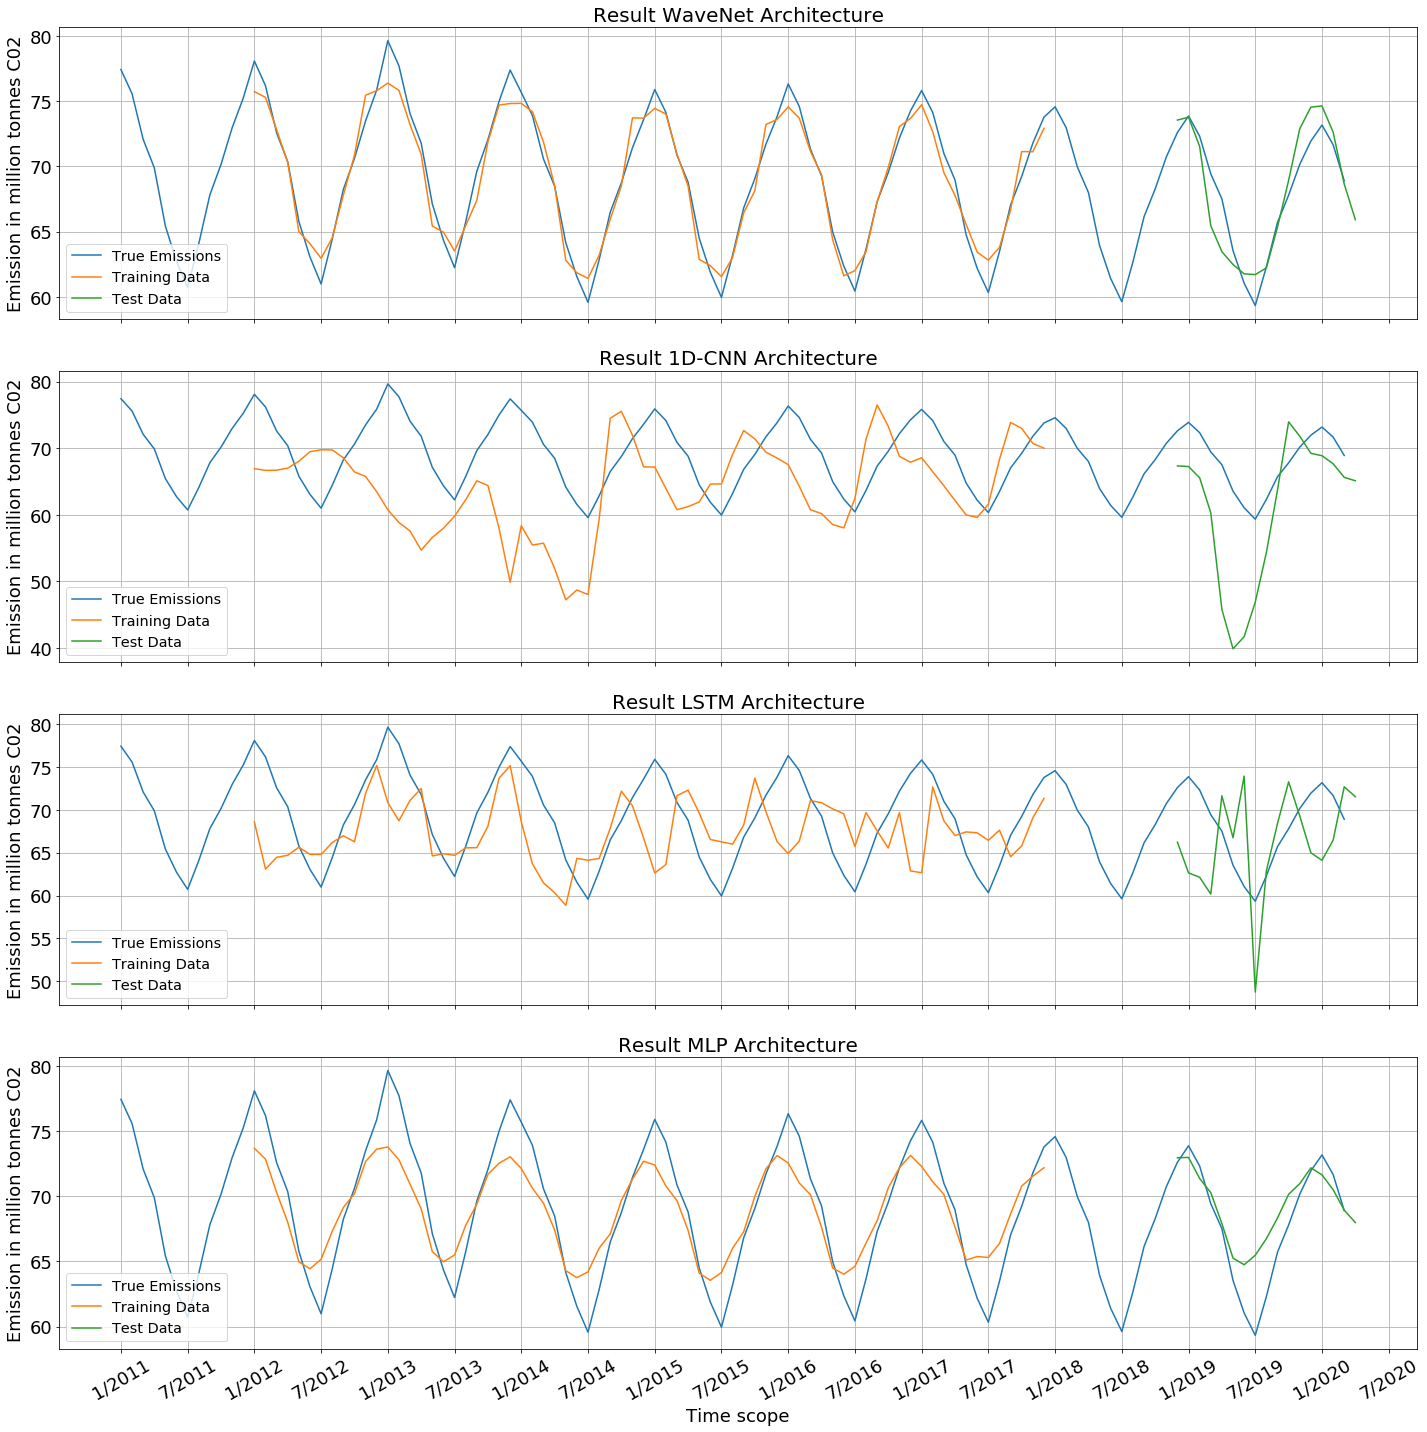

In [108]:
# Resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

fig, ax = plt.subplots(4, figsize=(20,20), sharex=True)

# WaveNet
ax[0].plot(emission_data[:], label='True Emissions')
ax[0].plot(trainPredict_wavenet, label='Training Data')
ax[0].plot(testPredict_wavenet, label='Test Data')
ax[0].set_title('Result WaveNet Architecture', fontsize=20)
ax[0].set_ylabel('Emission in million tonnes C02', fontsize=18)
ax[0].yaxis.set_tick_params(labelsize=18)
ax[0].legend(fontsize='x-large', loc='lower left')
ax[0].grid()

# 1D-CNN
ax[1].plot(emission_data[:], label='True Emissions')
ax[1].plot(trainPredict_cnn1D, label='Training Data')
ax[1].plot(testPredict_cnn1D, label='Test Data')
ax[1].set_title('Result 1D-CNN Architecture', fontsize=20)
ax[1].set_ylabel('Emission in million tonnes C02', fontsize=18)
ax[1].yaxis.set_tick_params(labelsize=18)
ax[1].legend(fontsize='x-large', loc='lower left')
ax[1].grid()

# LSTM
ax[2].plot(emission_data[:], label='True Emissions')
ax[2].plot(trainPredict_lstm, label='Training Data')
ax[2].plot(testPredict_lstm, label='Test Data')
ax[2].set_title('Result LSTM Architecture', fontsize=20)
ax[2].set_ylabel('Emission in million tonnes C02', fontsize=18)
ax[2].yaxis.set_tick_params(labelsize=18)
ax[2].legend(fontsize='x-large', loc='lower left')
ax[2].grid()

# MLP
ax[3].plot(emission_data[:], label='True Emissions')
ax[3].plot(trainPredict_mlp, label='Training Data')
ax[3].plot(testPredict_mlp, label='Test Data')
ax[3].set_title('Result MLP Architecture', fontsize=20)
ax[3].set_ylabel('Emission in million tonnes C02', fontsize=18)
ax[3].yaxis.set_tick_params(labelsize=18)
ax[3].legend(fontsize='x-large', loc='lower left')
ax[3].grid()

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.tight_layout()

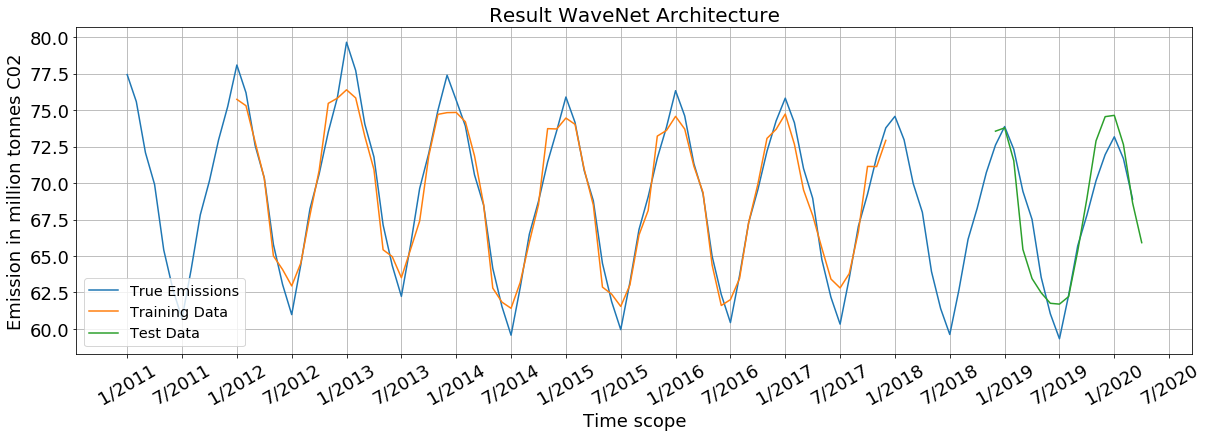

In [101]:
# WaveNet resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_wavenet, label='Training Data')
plt.plot(testPredict_wavenet, label='Test Data')
#plt.plot(prediction_wavenet, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Emission in million tonnes C02", fontsize=18)
plt.title('Result WaveNet Architecture', fontsize=20)
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()

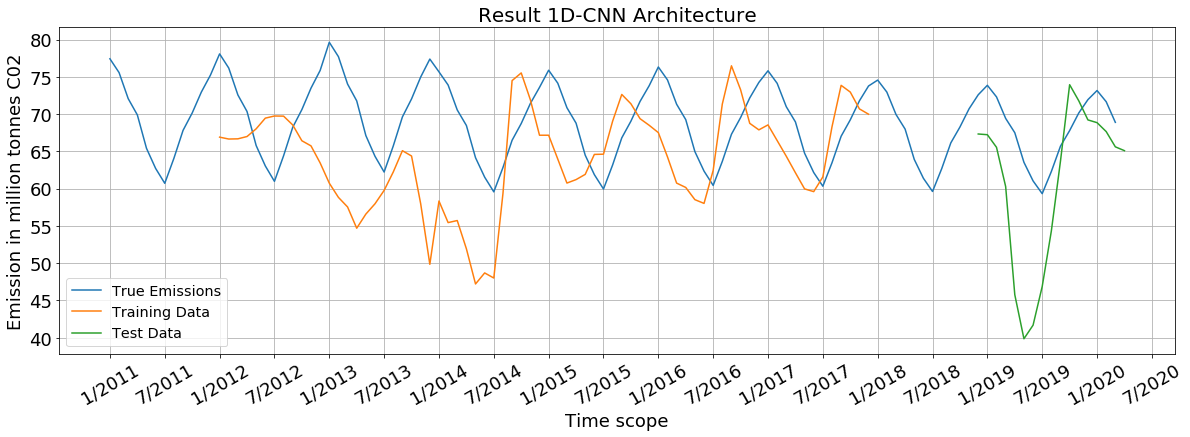

In [102]:
# 1D-CNN resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_cnn1D, label='Training Data')
plt.plot(testPredict_cnn1D, label='Test Data')
#plt.plot(prediction_cnn1D, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Emission in million tonnes C02", fontsize=18)
plt.title('Result 1D-CNN Architecture', fontsize=20)
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()

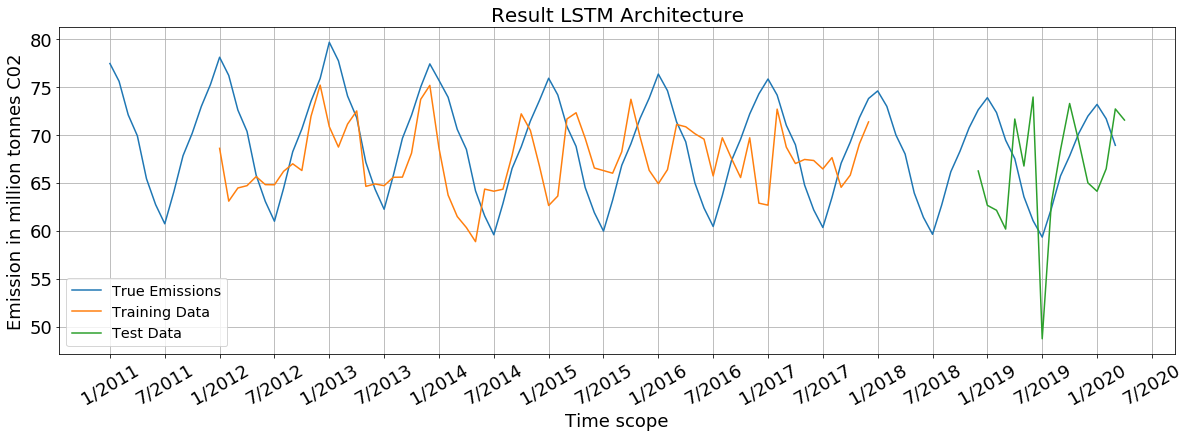

In [105]:
# LSTM resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_lstm, label='Training Data')
plt.plot(testPredict_lstm, label='Test Data')
#plt.plot(prediction_lstm, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Emission in million tonnes C02", fontsize=18)
plt.title('Result LSTM Architecture', fontsize=20)
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()

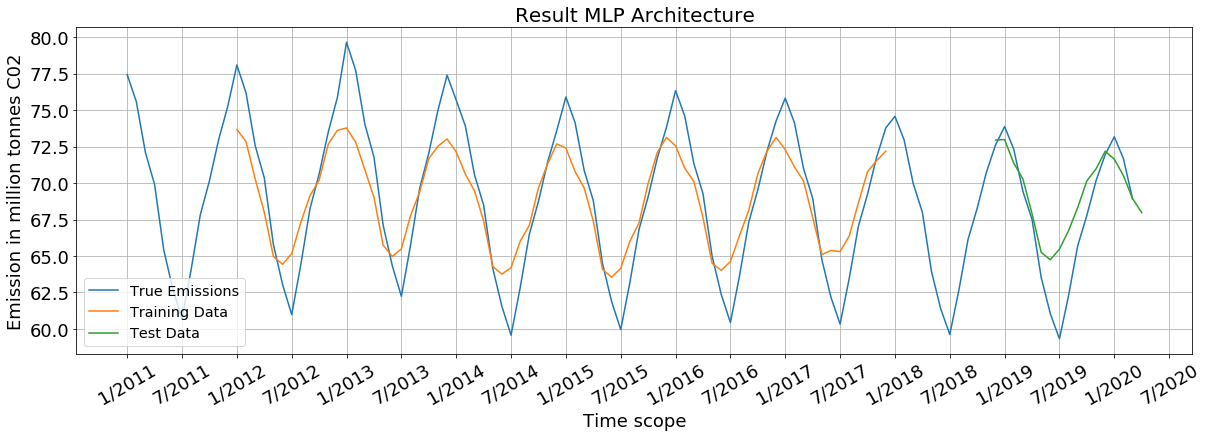

In [104]:
# MLP resulting plot: True Emissions, training data prediction, test data prediction, horizon prediction

plt.figure(figsize=(20,6))
plt.plot(emission_data[:], label='True Emissions')
plt.plot(trainPredict_mlp, label='Training Data')
plt.plot(testPredict_mlp, label='Test Data')
#plt.plot(prediction_mlp, label='Forecast')

plt.xticks(np.arange(len(time_scope))[::6], time_scope[::6], rotation=30, fontsize=18)
plt.xlabel("Time scope", fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Emission in million tonnes C02", fontsize=18)
plt.title('Result MLP Architecture', fontsize=20)
plt.legend(fontsize='x-large', loc='lower left')
plt.grid()
plt.show()